# BeamForming

In [1]:
# Imports
import h5py
import indolocate
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Dataset (WILD v2): https://www.kaggle.com/c/wild-v2
WILD_Dataset = "/mnt/LabData/datasets/indoor_localization/wild-v2/training_data_env1.h5"
dataset = h5py.File(WILD_Dataset, "r")

# Data initilization
csi_real = np.array(dataset["channels/real"])   # (6, 4, 234, 17276) -> (AP, Anteena, subcarrrier, real_csi)
csi_imag = np.array(dataset["channels/imag"])   # (6, 4, 234, 17276) -> (AP, Anteena, subcarrrier, imag_csi)
rssi_data = np.array(dataset["rssi"])           # (6, 17276)    -> (AP's RSSI, samples)
ap_locs = np.array(dataset["AP_locs"])          # (2, 4, 6)     -> (AP's Postion, Antenna, AP)
true_locs = np.array(dataset["labels"])         # (2, 17276)    -> (Target's Postion, samples)
d = np.array(dataset["opt/ANT_SEP"]).flatten()[0]
f = np.array(dataset["opt/CENTER_FREQ"]).flatten()[0]
bw = np.array(dataset["opt/BW"]).flatten()[0]

# Parameter initilization
csi_data = csi_real + 1j*csi_imag                           # shape (6, 4, 234, 17276)  -> (AP, Anteena, subcarrrier, csi)
ap_pos = np.mean(ap_locs, axis=1).T                         # Shape (6, 2)              -> (AP, (x, y))
true_pos = true_locs.T                                      # Shape (17276, 2)          -> (samples, (x, y))
pred_pos = np.zeros(true_pos.shape)                         # Shape (17276, 2)          -> (samples, (x, y))
aoa_final = np.zeros((true_pos.shape[0], ap_pos.shape[0]))   # shape (17276, 6)          -> (samples, (AoA))


In [ ]:
# =======================
# AoA Calculation (Mean)
# =======================

# Compute phase
phase = np.angle(csi_data)  # Shape: (6, 4, 234, 17276)

# Compute phase differences between adjacent antennas in range [-π, π]
delta_phase = (np.diff(phase, axis=1) + np.pi) % (2 * np.pi) - np.pi  # Shape: (6, 3, 234, 17276)

# Compute AoA (in radians)
aoa = np.arcsin(delta_phase / np.pi)  # Shape: (6, 3, 234, 17276)

# Average over antennas and subcarriers
aoa_final = np.mean(aoa, axis=(1, 2)).T  # Shape: (17276, 6)

In [3]:
# ===============================================
# AoA Calculation (MUSIC)
# ===============================================

# Loop over CSI samples
for sample in range(csi_data.shape[3]):  
    # Loop over Access Points (APs)
    for ap in range(csi_data.shape[0]):  
        # Extract CSI matrix for the given AP and sample (Antenna × Subcarrier)
        csi_matrix = csi_data[ap, :, :, sample]  # Shape: (4, 234)
        
        # Apply MUSIC algorithm to get the single AoA value
        aoa_final[sample, ap], _ = indolocate.beamformers.apply_MUSIC(csi_matrix, d, f, 1)  

/tmp/ipykernel_115985/1717659226.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  aoa_final[sample, ap], _ = indolocate.beamformers.apply_MUSIC(csi_matrix, d, f, 1)


In [4]:
# ===============================================
# Position Estimation (Least Squares)
# ===============================================

# Compute least squares for each sample
for i in range(aoa_final.shape[0]):  
    tan_theta = np.tan(np.radians(aoa_final[i, :]))  # Convert to radians, Shape: (6,)

    # Construct Q and F matrices
    Q = np.column_stack([tan_theta, -np.ones_like(tan_theta)])  # Shape: (6, 2)
    F = ap_pos[:, 0] * tan_theta - ap_pos[:, 1]  # Shape: (6,)

    # Solve least squares: X = (Q^T Q)^(-1) Q^T F
    pred_pos[i] = np.linalg.pinv(Q.T @ Q) @ Q.T @ F  # Shape: (2,)

In [5]:
# =========================
# Display Results
# =========================

print("Time Step |  True Position (x, y)  |  Estimated Position (x, y)")
print("---------------------------------------------------------------")
for t in range(0, 20):  # Print every 500th time step
    true_x, true_y = true_pos[t]
    estd_x, estd_y = pred_pos[t]
    print(f"{t:9d} | ({true_x:9.2f}, {true_y:9.2f}) | ({estd_x:9.2f}, {estd_y:9.2f})")
print("")

indolocate.evaluate_location(true_pos, pred_pos)


Time Step |  True Position (x, y)  |  Estimated Position (x, y)
---------------------------------------------------------------
        0 | (     6.80,    -14.17) | (     7.91,     -1.91)
        1 | (     6.29,     -6.12) | (    -4.04,     -0.00)
        2 | (     7.07,     -0.14) | (    -0.62,     -1.54)
        3 | (     7.18,     -7.30) | (    11.18,     -7.40)
        4 | (     6.19,    -13.93) | (    11.09,     -6.04)
        5 | (     0.61,     -1.95) | (     6.77,      0.00)
        6 | (    -3.72,      0.06) | (    17.54,     -0.00)
        7 | (     7.32,     -7.98) | (    -7.40,     -2.85)
        8 | (     6.29,      0.53) | (    17.54,      0.00)
        9 | (     7.13,     -4.66) | (    -9.56,    -13.65)
       10 | (     3.18,    -14.65) | (    17.18,     -0.00)
       11 | (     9.96,      0.50) | (    17.54,     -0.00)
       12 | (     7.06,      1.56) | (    -5.10,     -5.46)
       13 | (     3.84,      1.02) | (     6.77,     -0.00)
       14 | (     2.32,     -2.2

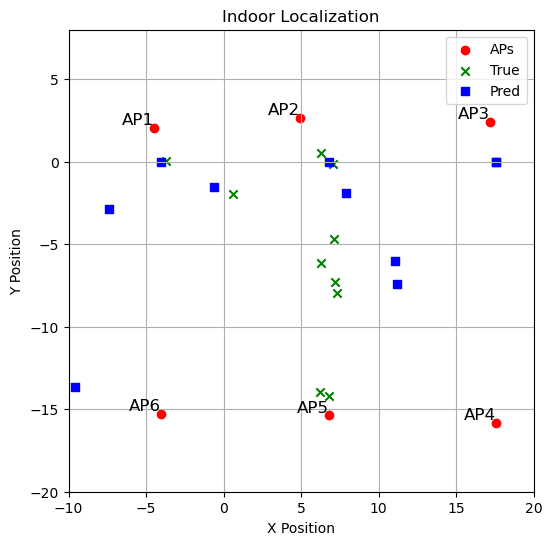

In [6]:
import matplotlib.pyplot as plt

samples = 10

true = true_pos[:samples, :]
pred = pred_pos[:samples, :]

# Plot AP positions
plt.figure(figsize=(6, 6))
plt.scatter(ap_pos[:, 0], ap_pos[:, 1], c="red", marker="o", label="APs")  # APs in red circles
plt.scatter(true[:, 0], true[:, 1], c="green", marker="x", label="True")   # True positions as green Xs
plt.scatter(pred[:, 0], pred[:, 1], c="blue", marker="s", label="Pred")    # Predicted positions as blue squares


plt.xlabel("X Position")
plt.ylabel("Y Position")
plt.title("Indoor Localization")
plt.xlim(-10, 20)
plt.ylim(-20, 8)  # Fixed axis ordering
plt.legend()
plt.grid(True)

# Annotate AP numbers
for i, (x, y) in enumerate(ap_pos):
    plt.text(x, y, f"AP{i+1}", fontsize=12, ha="right", va="bottom", color="black")

plt.show()